## Import libraries

In [13]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import ETFs as etfs

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import layers


## Read CSV

In [14]:
data = pd.read_csv('../../dataProcessing/assets_filled.csv', parse_dates=['Date'])
print(data.columns.tolist())
data.set_index('Date', inplace=True)
display(data)


['Date', 'AIEQ', 'ASHR.L', 'BCHN.L', 'CORN', 'DBO', 'EDEN', 'EMXC', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWQ', 'EWS', 'EWU', 'EWW', 'GLD', 'IDUP.L', 'IEMG', 'INDA', 'KSA', 'PSCC', 'SEMI.AS', 'SLV', 'SPY', 'TLT', 'USO', 'VDE', 'VDNR.L', 'VGK', 'VNQ', 'VPL', 'XMAF.L']


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,21.902443,6.246624,40.000000,42.619999,26.042212,22.380077,42.757008,12.307330,20.625574,14.720881,...,28.830000,100.450684,83.888573,317.519989,69.905655,42.300957,27.664722,34.591938,33.707809,6.78375
2012-01-04,21.902443,6.246624,40.000000,42.509998,26.165096,22.380077,42.757008,12.452251,20.587934,14.581520,...,28.389999,100.608261,82.891136,318.160004,70.114944,42.300957,27.328695,34.000530,33.888020,6.69750
2012-01-05,21.902443,6.246624,40.000000,41.509998,25.814005,22.380077,42.757008,12.290605,20.459967,14.412823,...,28.510000,100.876129,82.743668,313.359985,69.817871,42.300957,26.831099,34.319885,33.472149,6.68250
2012-01-06,21.902443,6.246624,40.000000,41.349998,25.919331,22.380077,42.757008,12.128960,20.249193,14.148770,...,27.910000,100.616127,83.396919,313.760010,69.392532,42.300957,26.462753,34.207520,33.070118,6.72625
2012-01-09,21.902443,6.246624,40.000000,42.189999,25.831558,22.380077,42.757008,12.167979,20.309414,14.207450,...,28.129999,100.860359,83.249390,312.640015,69.655830,42.300957,26.663073,34.089233,33.097832,6.69625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,38.276001,10.405000,100.550003,18.930000,14.140000,107.930000,56.490002,23.700001,41.509998,38.029999,...,29.959999,574.080017,88.790054,74.879997,129.030991,140.270004,71.730003,90.728004,74.690002,8.28750
2025-03-25,38.380001,10.440000,100.720001,18.770000,14.030000,107.330002,56.580002,23.809999,41.709999,38.380001,...,30.580000,575.460022,88.780167,74.820000,129.460007,140.479996,72.160004,89.709999,75.089996,8.14875
2025-03-26,37.854000,10.400000,98.169998,18.559999,14.110000,105.839996,56.080002,23.709999,41.380001,37.560001,...,30.530001,568.590027,88.196609,75.419998,130.250000,139.595001,71.139999,90.059998,74.410004,8.14500


In [15]:
first_prices = data.iloc[:1]
first_prices.values

array([[ 21.90244293,   6.24662399,  40.        ,  42.61999893,
         26.04221153,  22.38007736,  42.7570076 ,  12.30733013,
         20.62557411,  14.72088146,  10.45192623,  30.00427818,
         14.19258881,  13.14745522,  19.75927925,  41.37704086,
        155.91999817,  13.62710571,  35.37962341,  23.19848824,
         20.75997353,   8.67868042,   5.19500017,  28.82999992,
        100.45068359,  83.88857269, 317.51998901,  69.90565491,
         42.30095673,  27.66472244,  34.59193802,  33.70780945,
          6.78375006]])

In [16]:
normalized_data = data.copy()
normalized_data = data / first_prices.values
normalized_data

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-04,1.000000,1.000000,1.000000,0.997419,1.004719,1.000000,1.000000,1.011775,0.998175,0.990533,...,0.984738,1.001569,0.988110,1.002016,1.002994,1.000000,0.987854,0.982903,1.005346,0.987286
2012-01-05,1.000000,1.000000,1.000000,0.973956,0.991237,1.000000,1.000000,0.998641,0.991971,0.979073,...,0.988900,1.004235,0.986352,0.986898,0.998744,1.000000,0.969867,0.992135,0.993009,0.985075
2012-01-06,1.000000,1.000000,1.000000,0.970202,0.995281,1.000000,1.000000,0.985507,0.981752,0.961136,...,0.968089,1.001647,0.994139,0.988158,0.992660,1.000000,0.956552,0.988887,0.981082,0.991524
2012-01-09,1.000000,1.000000,1.000000,0.989911,0.991911,1.000000,1.000000,0.988677,0.984671,0.965122,...,0.975720,1.004078,0.992381,0.984631,0.996426,1.000000,0.963793,0.985468,0.981904,0.987102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1.747568,1.665700,2.513750,0.444158,0.542965,4.822593,1.321187,1.925682,2.012550,2.583405,...,1.039195,5.715043,1.058428,0.235828,1.845788,3.316001,2.592833,2.622808,2.215807,1.221669
2025-03-25,1.752316,1.671303,2.518000,0.440404,0.538741,4.795783,1.323292,1.934619,2.022247,2.607181,...,1.060701,5.728782,1.058311,0.235639,1.851925,3.320965,2.608376,2.593379,2.227674,1.201216
2025-03-26,1.728300,1.664899,2.454250,0.435476,0.541813,4.729206,1.311598,1.926494,2.006247,2.551478,...,1.058966,5.660390,1.051354,0.237528,1.863226,3.300044,2.571506,2.603497,2.207500,1.200663


In [17]:
binary_targets = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
binary_targets.set_index('Date', inplace=True)


In [18]:
def create_X_y_rolling(df, target_label, window_size):
    X, y, labels, first_values = [], [], [], []
    for i in range(len(df) - window_size):
        window = df.iloc[i:i+window_size]
        X.append(window.values)
        
        y_target = df.iloc[i+window_size]
        y.append(y_target.values)
        
        l = target_label.iloc[i+window_size]
        labels.append(l)
                
    X = np.array(X)
    y = np.array(y)
    labels = np.array(labels)
    return X, y, labels



## Train the model

In [19]:
window_size = 30
dataset_size = len(normalized_data)
train_size = int(dataset_size * 0.8)
test_size = int(dataset_size * 0.1)
val_size = dataset_size - train_size - test_size

train_data = normalized_data.iloc[:train_size]
val_data = normalized_data.iloc[train_size:train_size + val_size]
test_data = normalized_data.iloc[train_size + val_size:]

binary_targets_train = binary_targets.iloc[:train_size]
binary_targets_val = binary_targets.iloc[train_size:train_size + val_size]
binary_targets_test = binary_targets.iloc[train_size + val_size:]



train_mean = train_data.mean()
train_std = train_data.std()
val_mean = val_data.mean()
val_std = val_data.std()
test_mean = test_data.mean()
test_std = test_data.std()

train_scaled = (train_data - train_mean) / train_std
val_scaled = (val_data - val_mean) / val_std
test_scaled = (test_data - test_mean) / test_std



X_train, y_train, labels_train = create_X_y_rolling(train_scaled, binary_targets_train, window_size)
X_val, y_val, labels_val = create_X_y_rolling(val_scaled, binary_targets_val, window_size)
X_test, y_test, labels_test = create_X_y_rolling(test_scaled, binary_targets_test, window_size)

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, labels_train.shape, labels_val.shape, labels_test.shape


((2696, 30, 33),
 (2696, 33),
 (312, 30, 33),
 (312, 33),
 (310, 30, 33),
 (310, 33),
 (2696, 33),
 (312, 33),
 (310, 33))

In [20]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2), 

    LSTM(64, return_sequences=False, activation='linear'),
    Dropout(0.2),  

    Dense(y_train.shape[1] )
])


cp = ModelCheckpoint(filepath='model/best_first_scaled.keras', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss=MeanSquaredError(), 
              optimizer=Adam(learning_rate=0.001), 
              metrics=[MeanSquaredError()])

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[cp]
)
# model.summary()



Epoch 1/20


c:\Users\Shelly\Desktop\BachelorProject\BAvenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - loss: 0.4783 - mean_squared_error: 0.4782 - val_loss: 0.5983 - val_mean_squared_error: 0.6029
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.1345 - mean_squared_error: 0.1344 - val_loss: 0.5434 - val_mean_squared_error: 0.5483
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0994 - mean_squared_error: 0.0995 - val_loss: 0.4988 - val_mean_squared_error: 0.5035
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0892 - mean_squared_error: 0.0893 - val_loss: 0.4740 - val_mean_squared_error: 0.4785
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0775 - mean_squared_error: 0.0775 - val_loss: 0.4485 - val_mean_squared_error: 0.4528
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.4362 - val_mean_squared_error: 0.4403
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0626 - mean_squared_error: 0.0626 - val_loss: 0.4179 - val_mean_squa

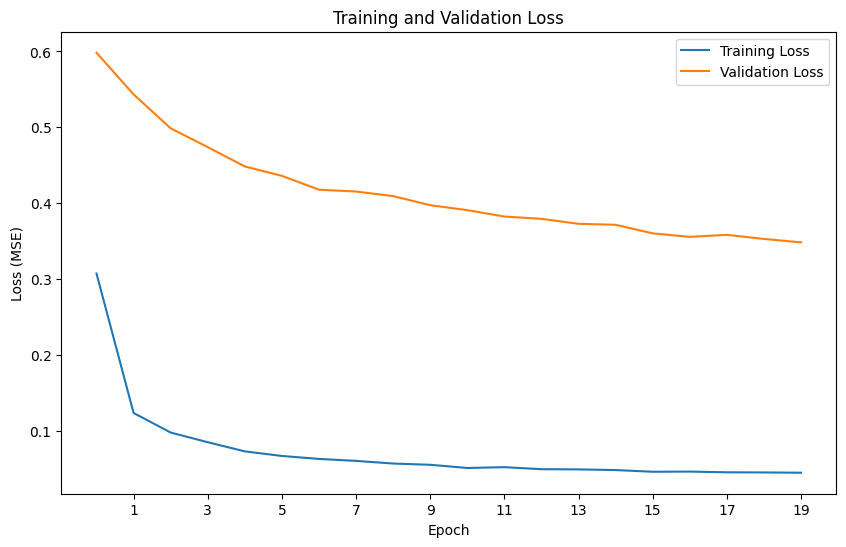

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['mean_squared_error'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
xticks = np.arange(1, 21, 2)
plt.xticks(xticks)
plt.title('Training and Validation Loss')
plt.show()

## Predictions

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,34.731123,9.154995,85.735294,19.507823,13.674326,113.152209,53.850044,22.931103,35.439131,29.032339,...,23.238594,513.779454,88.538893,71.846650,119.594654,121.832614,63.067897,84.564714,69.832902,6.538564
2024-01-18,34.544516,9.121000,85.427195,19.477887,13.651617,112.914744,53.729614,22.835226,35.267425,28.785096,...,23.132593,512.670189,88.539476,71.750051,119.276982,121.375039,62.831028,84.377643,69.711148,6.478347
2024-01-19,34.400384,9.092998,85.261546,19.453401,13.640353,112.721329,53.645071,22.755024,35.136113,28.609109,...,23.031916,511.617297,88.507172,71.720666,119.032246,121.024100,62.650377,84.162123,69.619779,6.432587
2024-01-22,34.319346,9.074381,85.252575,19.438036,13.640171,112.651897,53.624815,22.716432,35.081995,28.534144,...,22.962782,511.190601,88.475747,71.751089,118.910824,120.876730,62.556637,84.017255,69.580225,6.410961
2024-01-23,34.269728,9.058752,85.368445,19.424859,13.646097,112.687122,53.640082,22.698010,35.069064,28.511677,...,22.880859,511.322560,88.454030,71.813502,118.817041,120.883996,62.522067,83.929296,69.568411,6.394195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,37.705824,10.350024,100.989068,18.590452,13.968924,123.434496,57.850519,25.488545,41.102902,35.654223,...,28.344712,570.375523,91.095058,72.710693,124.506413,138.923755,69.400495,89.781648,74.565040,7.526172
2025-03-25,37.706429,10.363608,101.195533,18.600059,13.990269,123.483378,57.957011,25.483926,41.165903,35.646603,...,28.349012,570.857821,91.063833,72.779751,125.045659,138.950933,69.409707,89.743863,74.588805,7.547278
2025-03-26,37.736286,10.378467,101.500467,18.613503,14.010799,123.537399,58.068084,25.483089,41.229086,35.616643,...,28.357417,571.562565,91.043448,72.834580,125.525536,139.045971,69.407486,89.754317,74.610400,7.559711


<Axes: xlabel='Date'>

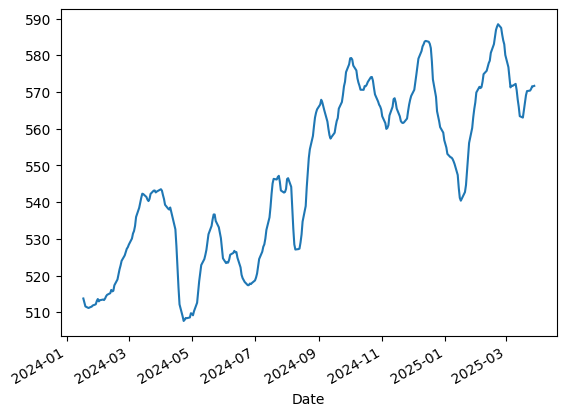

In [30]:
model = load_model('model/best_first_scaled.keras')
Y_pred = model.predict(X_test)
# display(pd.Series(Y_pred))
index_series = data.index[-len(y_test):]
Y_pred_denormalized = (Y_pred * test_std.values + test_mean.values)* first_prices.values

Y_pred_df = pd.DataFrame(Y_pred_denormalized, index = index_series, columns = data.columns)

display(Y_pred_df)

Y_pred_df["SPY"].plot()



In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming y_test and y_pred are your actual and predicted values
mse = mean_squared_error(y_test, Y_pred)
mae = mean_absolute_error(y_test, Y_pred)
r2 = r2_score(y_test, Y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Squared Error: 0.4208
Mean Absolute Error: 0.5034
R-squared: 0.5162


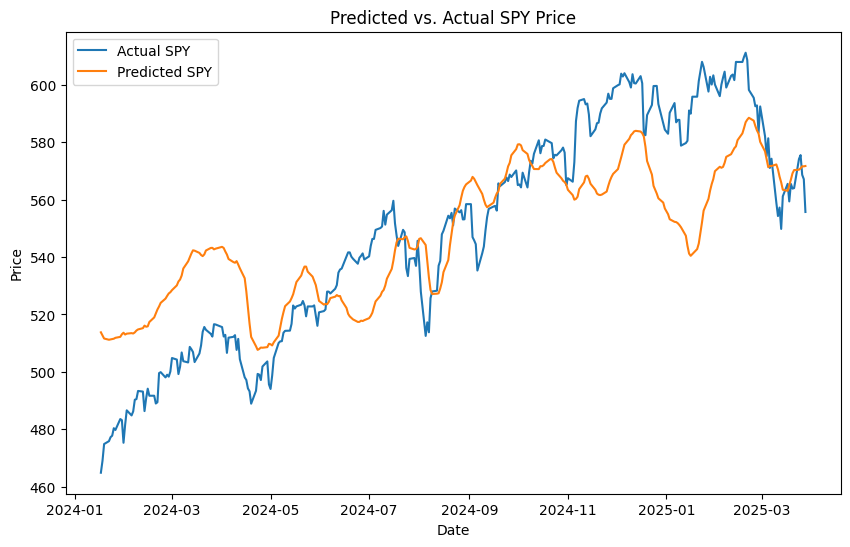

In [33]:
y_actual = pd.DataFrame((y_test*test_std.values + test_mean.values)* first_prices.values, index=index_series, columns=data.columns)

plt.figure(figsize=(10,6))
plt.plot(y_actual["SPY"], label='Actual SPY')
plt.plot(Y_pred_df["SPY"], label='Predicted SPY')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Predicted vs. Actual SPY Price')
plt.legend()
plt.show()


In [34]:
print("Mean of actual normalized prices:", np.mean(y_test))
print("Mean of predicted normalized prices:", np.mean(Y_pred))


Mean of actual normalized prices: 0.10333002080515448
Mean of predicted normalized prices: 0.09313427


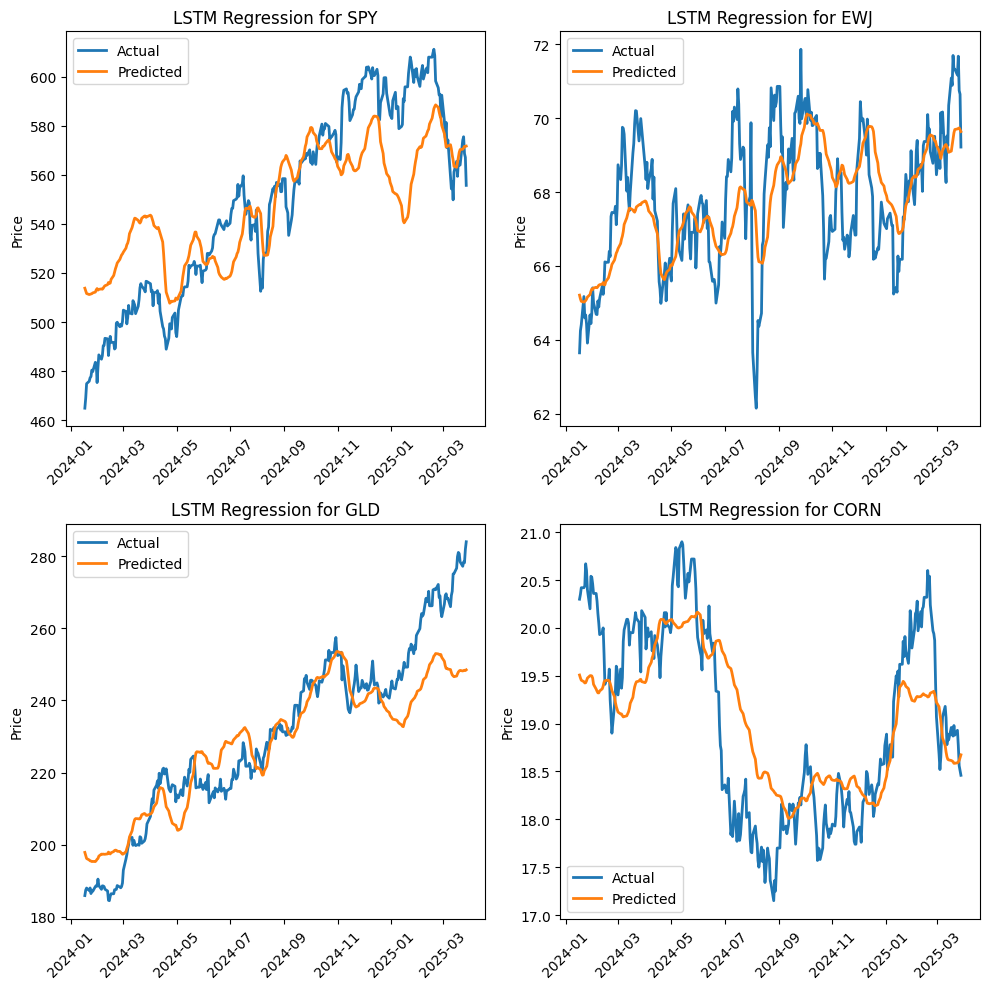

In [35]:
ticker_name = ['SPY', 'EWJ', 'GLD', 'CORN']  

num_plots = len(ticker_name)
num_cols = 2
num_rows = (num_plots + num_cols - 1) // num_cols


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 5*num_rows))
axes = axes.flatten() 


for i, ticker in enumerate(ticker_name):
    ax = axes[i]
    ax.plot(y_actual[ticker], label='Actual', linewidth=2)
    ax.plot(Y_pred_df[ticker], label='Predicted', linewidth=2)
    ax.set_title(f'LSTM Regression for {ticker}')
    ax.set_ylabel('Price')
    ax.tick_params(axis='x', rotation=45)

    ax.legend()

for j in range(len(ticker_name), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [36]:
label = pd.read_csv('../../dataProcessing/target_binary.csv', parse_dates=['Date'])
label_test = label.iloc[-len(y_test):]
label_test.set_index('Date', inplace=True)
display(label_test)

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2024-01-18,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,0,1,1,0,1,1
2024-01-19,1,1,0,1,0,0,1,1,1,1,...,0,1,1,0,1,1,1,1,1,0
2024-01-22,1,0,1,0,1,0,0,0,0,1,...,0,1,1,1,1,1,1,1,1,1
2024-01-23,1,1,0,1,0,0,0,1,1,0,...,1,1,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,1,1,1,1,0,1,1,1,0,...,0,1,0,1,1,1,0,1,1,0
2025-03-25,1,1,1,0,0,0,1,1,1,1,...,1,1,0,0,1,1,1,0,1,0
2025-03-26,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0


In [37]:
Y_pred_df

,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,34.731123,9.154995,85.735294,19.507823,13.674326,113.152209,53.850044,22.931103,35.439131,29.032339,...,23.238594,513.779454,88.538893,71.846650,119.594654,121.832614,63.067897,84.564714,69.832902,6.538564
2024-01-18,34.544516,9.121000,85.427195,19.477887,13.651617,112.914744,53.729614,22.835226,35.267425,28.785096,...,23.132593,512.670189,88.539476,71.750051,119.276982,121.375039,62.831028,84.377643,69.711148,6.478347
2024-01-19,34.400384,9.092998,85.261546,19.453401,13.640353,112.721329,53.645071,22.755024,35.136113,28.609109,...,23.031916,511.617297,88.507172,71.720666,119.032246,121.024100,62.650377,84.162123,69.619779,6.432587
2024-01-22,34.319346,9.074381,85.252575,19.438036,13.640171,112.651897,53.624815,22.716432,35.081995,28.534144,...,22.962782,511.190601,88.475747,71.751089,118.910824,120.876730,62.556637,84.017255,69.580225,6.410961
2024-01-23,34.269728,9.058752,85.368445,19.424859,13.646097,112.687122,53.640082,22.698010,35.069064,28.511677,...,22.880859,511.322560,88.454030,71.813502,118.817041,120.883996,62.522067,83.929296,69.568411,6.394195
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,37.705824,10.350024,100.989068,18.590452,13.968924,123.434496,57.850519,25.488545,41.102902,35.654223,...,28.344712,570.375523,91.095058,72.710693,124.506413,138.923755,69.400495,89.781648,74.565040,7.526172
2025-03-25,37.706429,10.363608,101.195533,18.600059,13.990269,123.483378,57.957011,25.483926,41.165903,35.646603,...,28.349012,570.857821,91.063833,72.779751,125.045659,138.950933,69.409707,89.743863,74.588805,7.547278
2025-03-26,37.736286,10.378467,101.500467,18.613503,14.010799,123.537399,58.068084,25.483089,41.229086,35.616643,...,28.357417,571.562565,91.043448,72.834580,125.525536,139.045971,69.407486,89.754317,74.610400,7.559711


In [38]:
y_test_shift = data[train_size + val_size + window_size - 1: -1]
y_test_shift_index = data.index[train_size + val_size + window_size-1: -1]

y_test_shift_df = pd.DataFrame(y_test_shift, index=y_test_shift_index, columns=data.columns)
y_test_shift_array = y_test_shift_df.values


predicted_directions = (Y_pred_df > y_test_shift_array).astype(int)
predicted_directions_df = pd.DataFrame(predicted_directions, index=index_series, columns=data.columns)
display(predicted_directions_df)


,AIEQ,ASHR.L,BCHN.L,CORN,DBO,EDEN,EMXC,EWA,EWC,EWG,...,SLV,SPY,TLT,USO,VDE,VDNR.L,VGK,VNQ,VPL,XMAF.L
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-17,1,1,1,0,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
2024-01-18,1,1,1,0,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
2024-01-19,1,1,1,0,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1
2024-01-22,1,1,1,0,1,1,1,1,0,1,...,1,1,0,1,1,1,1,1,1,0
2024-01-23,0,1,1,0,0,1,1,1,0,1,...,1,1,0,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-24,1,0,1,0,1,1,1,1,1,0,...,0,1,1,0,0,1,0,1,0,0
2025-03-25,0,0,1,0,0,1,1,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2025-03-26,0,0,1,0,0,1,1,1,0,0,...,0,0,1,0,0,0,0,1,0,0


In [39]:
actual_flat = label_test.to_numpy().flatten()
predicted_flat = predicted_directions_df.to_numpy().flatten()

matches = np.sum(actual_flat == predicted_flat)
percentage = (matches / len(actual_flat)) * 100
print(f"Match Percentage: {percentage:.2f}%")

accuracy = accuracy_score(actual_flat, predicted_flat)
print(f'Accuracy of the model: {accuracy:.4f}')

Match Percentage: 52.37%
Accuracy of the model: 0.5237


### Accuracy

In [40]:
yesterday_prices = data.iloc[-2]  
today_prices_actual = data.iloc[-1] 


Y_pred_mean = Y_pred.mean(axis=0)
Y_pred_real = Y_pred_mean * first_prices.values
today_prices_predicted = pd.Series(Y_pred_real.flatten(), index=data.columns)


comparison_df = pd.DataFrame({
    'Yesterday_actual': yesterday_prices,
    'Today_actual': today_prices_actual,
    'Today_pred': today_prices_predicted,
})

tickers_names = data.columns

correct_list = []
for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]

    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)

    if sign_actual == sign_pred:
        correct_list.append(1)
    else:
        correct_list.append(0)
comparison_df['Correct'] = correct_list

count_of_ones = correct_list.count(1)
print(f"Count of correct predictions: {count_of_ones}")
print(f"accuracy: {count_of_ones / len(correct_list)}")
# display(comparison_df)
save_df = pd.DataFrame()
save_df['Yesterday actual'] = comparison_df['Yesterday_actual'].apply(lambda x: round(x, 2))
save_df['Today actual'] = comparison_df['Today_actual'].apply(lambda x: round(x, 2))
save_df['Today pred target'] = comparison_df['Today_pred'].apply(lambda x: round(x, 2))
save_df['Correct'] = comparison_df['Correct']
display(save_df)
save_df.to_csv('rnn_regression.csv', index=True)


Count of correct predictions: 30
accuracy: 0.9090909090909091


,Yesterday actual,Today actual,Today pred target,Correct
AIEQ,37.66,36.85,3.25,1
ASHR.L,10.46,10.34,0.98,1
BCHN.L,97.08,92.71,6.38,1
CORN,18.51,18.46,-7.95,1
DBO,14.13,13.97,0.10,1
EDEN,105.33,105.17,3.08,1
EMXC,56.11,55.18,9.01,1
EWA,23.75,23.47,1.83,1
EWC,41.25,40.57,2.85,1
EWG,37.59,37.39,1.58,1


### Accuracy

In [ ]:
correct = 0
total = len(tickers_names)
print(f"Total Tickers: {total}")
print(f"used_data columns: {tickers_names}")

for ticker in tickers_names:
    yesterday = yesterday_prices[ticker]
    actual_today = today_prices_actual[ticker]
    predicted = today_prices_predicted[ticker]

    sign_actual = np.sign(actual_today - yesterday)
    sign_pred = np.sign(predicted - yesterday)

    if sign_actual == sign_pred:
        correct += 1

accuracy = correct / total
print(f"Accuracy: {accuracy:%}")


Total Tickers: 33
used_data columns: Index(['AIEQ', 'ASHR.L', 'BCHN.L', 'CORN', 'DBO', 'EDEN', 'EMXC', 'EWA', 'EWC',
       'EWG', 'EWH', 'EWJ', 'EWQ', 'EWS', 'EWU', 'EWW', 'GLD', 'IDUP.L',
       'IEMG', 'INDA', 'KSA', 'PSCC', 'SEMI.AS', 'SLV', 'SPY', 'TLT', 'USO',
       'VDE', 'VDNR.L', 'VGK', 'VNQ', 'VPL', 'XMAF.L'],
      dtype='object')
Accuracy: 51.515152%
